In [ ]:
import json
import pandas as pd
import os
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import statistics
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta


ta_root_dir = 'tennis_abstract'
ta_df_dir = 'tennis_abstract_dfs'
matchhead_verbose = ["date","tourn","surf","level","win/loss","rank","seed","entry","round",
                 "score","max_num_of_sets","opp","orank","oseed","oentry","ohand","obday",
                 "oheight","ocountry","oactive","time_minutes","aces","dfs","service_pts","first_serves_in","first_serves_won",
                 "second_serves_won",'service_games',"break_points_saved","break_points_faced",
                 "oaces","odfs","oservice_pts","ofirst_serves_in","ofirst_serves_won",
                 "osecond_serves_won",'oservice_games',"obreak_points_saved","obreak_points_faced", "obackhand", "chartlink",
                 "pslink","whserver","matchid","wh","roundnum","matchnum", "oforeign_key"]

round_vals = {
    'F': 1,
    'SF': 2,
    'QF': 3,
    'R16': 4,
    'R32': 5,
    'R64': 6,
    'R128': 7,
    'Q3': 8,
    'Q2': 9,
    'Q1': 10
}
round_vals = defaultdict(lambda: 11, round_vals)
prev_match_stats = ['prev_10_mean_serve_win_rate','prev_10_median_serve_win_rate','prev_10_mean_return_win_rate','prev_10_median_return_win_rate','rev_10_mean_first_serve_in_rate','rev_10_median_first_serve_in_rate','rev_10_mean_first_return_in_rate','rev_10_median_first_return_in_rate','rev_10_mean_first_return_win_rate','prev_10_median_first_return_win_rate','prev_10_mean_overall_win_rate','prev_10_median_overall_win_rate', 'prev_10_mean_second_serve_win_rate','prev_10_median_second_serve_win_rate','prev_10_mean_second_return_win_rate','prev_10_median_second_return_win_rate']
o_prev_match_stats = [f'o{n}' for n in prev_match_stats]


def calc_serve_win_rate(row):
    elems = ['first_serves_won', 'second_serves_won', 'service_pts']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['service_pts'])
    if denom == 0:
        return 0
    return (float(row['first_serves_won']) + float(row['second_serves_won'])) / denom

def calc_overall_win_rate(row):
    elems = ['first_serves_won', 'second_serves_won', 'ofirst_serves_won', 'osecond_serves_won', 'service_pts', 'oservice_pts']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['service_pts'] + row['oservice_pts'])
    if denom == 0:
        return 0
    return (float(row['first_serves_won']) + float(row['second_serves_won']) + (float(row['oservice_pts']) - float(row['first_serves_won']) - float(row['second_serves_won'])) ) / denom

def calc_return_win_rate(row):
    elems = ['ofirst_serves_won', 'osecond_serves_won', 'oservice_pts']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['oservice_pts'])
    if denom == 0:
        return 0
    return 1 - ((float(row['ofirst_serves_won']) + float(row['osecond_serves_won'])) / denom)

def calc_first_serve_win_rate(row):
    elems = ['first_serves_won', 'first_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['first_serves_in'])
    if denom == 0:
        return 0
    return float(row['first_serves_won']) / denom

def calc_first_serve_in_rate(row):
    elems = ['service_pts', 'first_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['service_pts'])
    if denom == 0:
        return 0
    return float(row['first_serves_in']) / denom

def calc_first_return_in_rate(row):
    elems = ['oservice_pts', 'ofirst_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['oservice_pts'])
    if denom == 0:
        return 0
    return float(row['ofirst_serves_in']) / denom

def calc_second_serve_win_rate(row):
    elems = ['second_serves_won', 'service_pts', 'first_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = (float(row['service_pts']) - float(row['first_serves_in']))
    if denom == 0:
        return 0
    return float(row['second_serves_won']) / denom
def calc_first_return_win_rate(row):
    elems = ['ofirst_serves_won', 'ofirst_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = float(row['ofirst_serves_in'])
    if denom == 0:
        return 0
    return 1 - (float(row['ofirst_serves_won']) / denom)

def calc_second_return_win_rate(row):
    elems = ['osecond_serves_won', 'oservice_pts', 'ofirst_serves_in']
    if any([row[elem] == '' for elem in elems]):
        return None
    denom = (float(row['oservice_pts']) - float(row['ofirst_serves_in']))
    if denom == 0:
        return 0
    return 1-(float(row['osecond_serves_won']) / denom)

def edit_df(name):
    if not os.path.exists(f'{ta_df_dir}/{name}.pkl'):
        return
    match_df = pd.read_pickle(f'{ta_df_dir}/{name}.pkl')
    match_df['formatted_opp'] = match_df['opp'].apply(lambda name: name.replace(' ', ''))
    match_df['round_val'] = match_df['round'].apply(lambda rd: round_vals[rd])
    match_df['serve_win_rate'] = match_df.apply(calc_serve_win_rate, axis=1)
    match_df['overall_win_rate'] = match_df.apply(calc_overall_win_rate, axis=1)
    match_df['return_win_rate'] = match_df.apply(calc_return_win_rate, axis=1)
    match_df['first_serve_in_rate'] = match_df.apply(calc_first_serve_in_rate, axis=1)
    match_df['first_return_in_rate'] = match_df.apply(calc_first_return_in_rate, axis=1)
    match_df['first_serve_win_rate'] = match_df.apply(calc_first_serve_win_rate, axis=1)
    match_df['second_serve_win_rate'] = match_df.apply(calc_second_serve_win_rate, axis=1)
    match_df['first_return_win_rate'] = match_df.apply(calc_first_return_win_rate, axis=1)
    match_df['second_return_win_rate'] = match_df.apply(calc_second_return_win_rate, axis=1)

    rows_to_go = match_df[match_df['serve_win_rate'].isna() | match_df['score'].str.contains('RET') | ~match_df['win/loss'].isin(['W', 'L']) ]
    # assert len(rows_to_go) < 0.15 * len(match_df)
    match_df.drop(rows_to_go.index, inplace=True)
    match_df.sort_index(ascending=False, inplace=True)
    window_size = 10
    match_df['prev_10_mean_serve_win_rate'] = match_df['serve_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_serve_win_rate'] = match_df['serve_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_return_win_rate'] = match_df['return_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_return_win_rate'] = match_df['return_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_first_serve_win_rate'] = match_df['first_serve_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_first_serve_win_rate'] = match_df['first_serve_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_first_serve_in_rate'] = match_df['first_serve_in_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_first_serve_in_rate'] = match_df['first_serve_in_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_first_return_in_rate'] = match_df['first_return_in_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_first_return_in_rate'] = match_df['first_return_in_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_first_return_win_rate'] = match_df['first_return_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_first_return_win_rate'] = match_df['first_return_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_overall_win_rate'] = match_df['overall_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_overall_win_rate'] = match_df['overall_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_second_serve_win_rate'] = match_df['second_serve_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_second_serve_win_rate'] = match_df['second_serve_win_rate'].rolling(window=window_size, closed='left').median()
    match_df['prev_10_mean_second_return_win_rate'] = match_df['second_return_win_rate'].rolling(window=window_size, closed='left').mean()
    match_df['prev_10_median_second_return_win_rate'] = match_df['second_return_win_rate'].rolling(window=window_size, closed='left').median()
    match_df = pd.concat([match_df, rows_to_go])
    match_df.sort_index(ascending=False, inplace=True)
    pd.to_pickle(match_df, f'{ta_df_dir}/{name}.pkl')


def get_player_nums(base_p_name):
    alcaraz_html_path = f'{ta_root_dir}/{base_p_name}.html'
    with open(alcaraz_html_path, 'r') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, "html.parser")
    script_tags = soup.find_all("script")
    ochoices = None
    for script in script_tags:
        if script.string:  # Ensure the script tag contains JavaScript code
            match = re.search(r'var\s+ochoices\s*=\s*(\[.*?\]);', script.string, re.DOTALL)
            if match:
                # Extract the JavaScript array or object
                ochoices_str = match.group(1)
                # Convert the JavaScript array/object to a Python object
                ochoices = eval(ochoices_str)
    ta_names = [v.replace(' ', '') for v in ochoices]
    edit_df(base_p_name)
    for name in ta_names:
        edit_df(name)
    def set_opposition_prev_match_stats(match):
        if not os.path.exists(f'{ta_df_dir}/{match["formatted_opp"]}.pkl'):
            return pd.Series([np.nan] * len(prev_match_stats), index=prev_match_stats)
        opp_df = pd.read_pickle(f'{ta_df_dir}/{match["formatted_opp"]}.pkl')
        opp_match_stats = opp_df.loc[(opp_df['date'] == match['date']) & (opp_df['formatted_opp'] == base_p_name) & (opp_df['round'] == match['round']), prev_match_stats]
        assert opp_match_stats.shape[0] <= 1
        # if opp_match_stats.shape[0] > 1:
        #     breakpoint()
        if opp_match_stats.shape[0] == 1:
            opp_match_stats = opp_match_stats.iloc[0]
            if len(opp_match_stats) == len(prev_match_stats):
                return opp_match_stats
        return pd.Series([np.nan] * len(prev_match_stats), index=prev_match_stats)
    match_df = pd.read_pickle(f'{ta_df_dir}/{base_p_name}.pkl')
    match_df[o_prev_match_stats] = np.nan
    match_df[o_prev_match_stats] = match_df.apply(set_opposition_prev_match_stats,axis=1)
    # match_df.loc[match_df['serve_win_rate'] < 0.3, 'score']
    X_cols1 = ['prev_10_mean_serve_win_rate', 'oprev_10_mean_return_win_rate']
    X_cols2 = ['prev_10_mean_first_serve_win_rate','prev_10_mean_first_serve_in_rate','oprev_10_mean_first_return_win_rate','oprev_10_mean_first_return_in_rate']
    X_cols3 = ['prev_10_mean_overall_win_rate', 'oprev_10_mean_overall_win_rate', 'prev_10_mean_serve_win_rate', 'oprev_10_mean_return_win_rate']
    matches_with_oprev_values = match_df.dropna(subset=o_prev_match_stats+prev_match_stats)
    def get_LR_vals(X_cols, idx):
        model = LinearRegression()
        X = matches_with_oprev_values[X_cols]
        y = matches_with_oprev_values['serve_win_rate']
        model.fit(X, y)
        match_df[f'LR_serve_win_rate_pred_{idx}'] = match_df.loc[matches_with_oprev_values.index].apply(lambda row: np.dot(row[X_cols],model.coef_)+model.intercept_, axis=1)
        return [round(c,2) for c in model.coef_ + [model.intercept_]]
    LR_vals1 = get_LR_vals(X_cols1, 1)
    LR_vals2 = get_LR_vals(X_cols2, 2)
    LR_vals3 = get_LR_vals(X_cols3, 3)
    matches_with_LR_pred = match_df.dropna(subset=['LR_serve_win_rate_pred_1'])
    real_vals = list(matches_with_LR_pred['serve_win_rate'])
    num_of_vals = len(real_vals)
    correct_threshold = 0.01
    predicted_vals_mean = matches_with_LR_pred['prev_10_mean_serve_win_rate']
    predicted_vals_median = matches_with_LR_pred['prev_10_median_serve_win_rate']
    predicted_vals_LR = matches_with_LR_pred['LR_serve_win_rate_pred_1']
    predicted_vals_LR_2 = matches_with_LR_pred['LR_serve_win_rate_pred_2']
    predicted_vals_LR_3 = matches_with_LR_pred['LR_serve_win_rate_pred_3']
    def get_SD(preds):
        return statistics.stdev(np.abs(np.subtract(real_vals, preds)))

    def get_MAE(preds):
        return np.abs(np.subtract(real_vals, preds)).mean()
    
    def get_correct_rate(preds):
        return float(len([p for p,r in zip(real_vals, preds) if abs(p-r)/r < correct_threshold])) / num_of_vals
    

    mean_SD = get_SD(predicted_vals_mean)
    median_SD = get_SD(predicted_vals_median)
    LR_SD = get_SD(predicted_vals_LR)
    LR_2_SD = get_SD(predicted_vals_LR_2)
    LR_3_SD = get_SD(predicted_vals_LR_3)
    mean_MAE = get_MAE(predicted_vals_mean)
    median_MAE = get_MAE(predicted_vals_median)
    LR_MAE = get_MAE(predicted_vals_LR)
    LR_2_MAE = get_MAE(predicted_vals_LR_2)
    LR_3_MAE = get_MAE(predicted_vals_LR_3)
    mean_correct_rate = get_correct_rate(predicted_vals_mean)
    median_correct_rate = get_correct_rate(predicted_vals_median)
    LR_correct_rate = get_correct_rate(predicted_vals_LR)
    LR_2_correct_rate = get_correct_rate(predicted_vals_LR_2)
    LR_3_correct_rate = get_correct_rate(predicted_vals_LR_3)

    return mean_MAE, median_MAE, LR_MAE, LR_2_MAE, LR_3_MAE 

# with open('api_p_keys_to_ta_names.json', 'r') as file:
#     players = json.load(file)
# ta_names = [v for k,v in players.items()]
# vals = []
# ta_names = ['CarlosAlcaraz', 'JannikSinner', 'AlexanderZverev','TaylorFritz' ,'DaniilMedvedev', 'AndreyRublev', 'StefanosTsitsipas', 'CasperRuud', 'TommyPaul', 'AlexDeMinaur','NovakDjokovic']
# for n in tqdm(ta_names):
#     vals.append(get_player_nums(n))


In [2]:
def add_opposition_stats(base_p_name):
    def set_opposition_prev_match_stats(match, base_p_name):
        if not os.path.exists(f'{ta_df_dir}/{match["formatted_opp"]}.pkl'):
            return pd.Series([np.nan] * len(prev_match_stats), index=prev_match_stats)
        opp_df = pd.read_pickle(f'{ta_df_dir}/{match["formatted_opp"]}.pkl')
        opp_match_stats = opp_df.loc[(opp_df['date'] == match['date']) & (opp_df['formatted_opp'] == base_p_name) & (opp_df['round'] == match['round']), prev_match_stats]
        # assert opp_match_stats.shape[0] <= 1
        if opp_match_stats.shape[0] > 1:
            breakpoint()
        if opp_match_stats.shape[0] == 1:
            opp_match_stats = opp_match_stats.iloc[0]
            if len(opp_match_stats) == len(prev_match_stats):
                return opp_match_stats
        return pd.Series([np.nan] * len(prev_match_stats), index=prev_match_stats)
    match_df = pd.read_pickle(f'{ta_df_dir}/{base_p_name}.pkl')
    match_df[o_prev_match_stats] = np.nan
    match_df[o_prev_match_stats] = match_df.apply(lambda row: set_opposition_prev_match_stats(row, base_p_name),axis=1)
    pd.to_pickle(match_df, f'{ta_df_dir}/{base_p_name}.pkl')

In [24]:
dfs_root_dir = 'tennis_abstract_dfs'
names = ['TaroDaniel', 'NikolozBasilashvili']
for i in range(len(names)):
    n = names[i]
    o = names[1-i]
    df = pd.read_pickle(f'{dfs_root_dir}/{n}.pkl')
    print(df.shape)
    df.drop_duplicates(subset=['date', 'tourn', 'formatted_opp', 'score', 'first_serve_win_rate', 'first_return_win_rate'], inplace=True)
    print(df.shape)
    pd.to_pickle(df, f'{dfs_root_dir}/{n}.pkl')
for n in names:
    edit_df(n)

(965, 77)
(965, 77)
(847, 89)
(847, 89)


In [3]:
dfs_root_dir = 'tennis_abstract_dfs'
ta_names = [name[:-4] for name in os.listdir(dfs_root_dir)]
for name in tqdm(ta_names):
    add_opposition_stats(name)

100%|██████████| 381/381 [03:36<00:00,  1.76it/s]


In [6]:
def get_stat_advantage(p_name,stats):
    match_df = pd.read_pickle(f'{dfs_root_dir}/{p_name}.pkl')
    # last_match_date = match_df.iloc[-1]['date']
    # lm_datetime = datetime.strptime(last_match_date, '%Y%m%d') - timedelta(days=365*1)
    # cutoff_date_str = datetime.strftime(lm_datetime, '%Y%m%d')
    cutoff_date_str = '20201231'
    # random_match_df.shape, random_match_df[random_match_df['date'] > cutoff_date_str].shape
    match_df = match_df[match_df['date'] > cutoff_date_str]
    stat_benefits = []
    for i in range(len(stats) - 1):
        stat1 = stats[i]
        stat2 = stats[i+1]
        if match_df.dropna(subset=[stat1, stat2]).empty:
            stat_benefits.append(None)
            continue
        # rally_strength = (abs((random_match_df['second_serve_win_rate'] * random_match_df['oprev_10_mean_second_return_win_rate'] / random_match_df['prev_10_mean_second_serve_win_rate']) - (random_match_df['second_return_win_rate'] * random_match_df['oprev_10_mean_second_serve_win_rate'] / random_match_df['prev_10_mean_second_return_win_rate'] ))).mean()
        stat_benefit = ((match_df[stat1]) - (match_df[stat2])).median()
        stat_benefits.append(stat_benefit)
    if match_df.dropna(subset=[stat1, stat2]).empty:
        stat_benefits.append(None)
    else:
        stat_benefits.append(abs(match_df['second_serve_win_rate'] - match_df['second_return_win_rate']).median())
    return stat_benefits


100%|██████████| 381/381 [00:02<00:00, 181.13it/s]


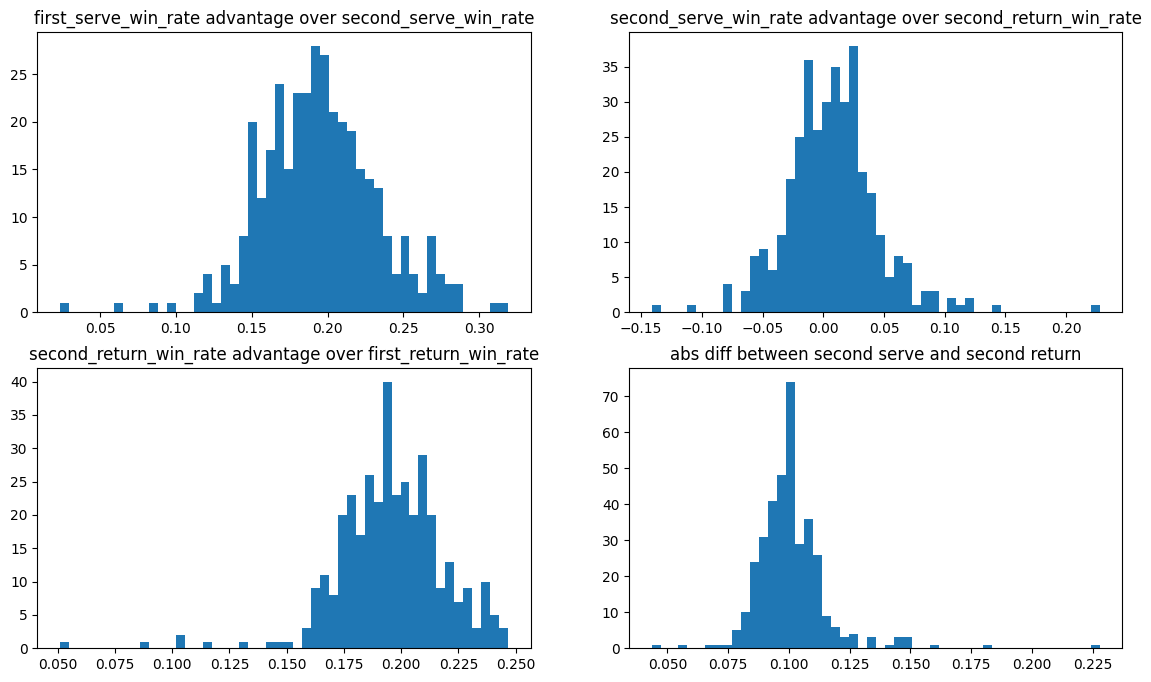

In [10]:
dfs_root_dir = 'tennis_abstract_dfs'
stats = ['first_serve_win_rate', 'second_serve_win_rate', 'second_return_win_rate', 'first_return_win_rate']
ta_names = [name[:-4] for name in os.listdir(dfs_root_dir)]
ta_names = sorted(ta_names)


advs = []
for name in tqdm(ta_names):
    adv = get_stat_advantage(name, stats)
    if all(adv):
        advs.append(adv)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))  

# # Plot each bar chart
# axes[0, 0].bar(x_labels, data1, color='b')
# axes[0, 0].set_title("Chart 1")
coords = [(0,0), (0,1), (1,0), (1,1)]
bins = 50
for i in range(len(stats)-1):
    stats1 = stats[i]
    stats2 = stats[i+1]
    specific_adv = [adv[i] for adv in advs]

    axes[*coords[i]].hist(specific_adv, bins=bins)
    axes[*coords[i]].set_title(f'{stats1} advantage over {stats2}')

abs_diff = [adv[-1] for adv in advs]
axes[*coords[-1]].hist(abs_diff, bins=bins)
axes[*coords[-1]].set_title(f'abs diff between second serve and second return')


plt.show()

In [6]:
import math
def analytic_game_prob(point_win_prob):
    p = point_win_prob
    return (p**4/(p**2 + (1-p)**2)) * (-8*p**3 + 28*p**2-34*p + 15)

def f(p1, p2, x):
    down = math.floor((7+x)/2)
    up = math.ceil((7+x)/2)
    total = 0
    for k in range(7-down, up+1):
        a = k
        b = up-k
        c = 7-k
        d = down - (7-k)
        temp = math.comb(up-1, k-1) * math.comb(down, 7-k) * (p1**a) * ((1-p1)**(b)) * (p2**(c)) * ((1-p2)**(d)) 
        # print(f'{k=}, {temp=}, {a=}, {b=}, {c=}, {d=}')
        total += temp
    # print(down)
    # print(up)
    return total

ps = 0.7
r = 0.4
dwin_prob = (r*ps)/(1-r-ps+2*r*ps)
d_prob = 0
for s in range(0, 7):
    d_prob += math.comb(6, s)**2 * (ps**s) * ((1-ps)**(6-s)) * (r**(6-s)) * ((1-r)**s)
tiebreak_total = 0
for x in [1,2,5]:
    tiebreak_total += f(r, ps, x)
for x in [0, 3, 4]:
    tiebreak_total += f(ps, r, x)

tiebreak_total += d_prob * dwin_prob
print(tiebreak_total)


0.6629731827478261


In [7]:
def set_f_even(p1, p2, x):
    total = 0
    up = 3+x
    down = 3-x
    for r in range(down, up+1):
        a = r
        b = 3+x-r
        c = 6-r
        d = x+r-3
        temp = math.comb(2+x, r-1) * math.comb(3+x, 6-r) * (p1**a) * ((1-p1)**(b)) * (p2**(c)) * ((1-p2)**(d)) 
        total += temp
    return total

def set_f_odd(p1, p2, x):
    total = 0
    up = 4+x
    down = 3-x
    for s in range(down, up+1):
        a = s
        b = 4+x-s
        c = 6-s
        d = x+s-3
        temp = math.comb(3+x, s-1) * math.comb(3+x, 6-s) * (p1**a) * ((1-p1)**(b)) * (p2**(c)) * ((1-p2)**(d)) 
        total += temp
    return total

ps = 0.7
r = 0.4
pS = analytic_game_prob(ps)
pR = analytic_game_prob(r)
set_total = 0
for x in [0,1,2]:
    set_total += set_f_even(pR, pS, x)
for x in [0,1]:
    set_total += set_f_odd(pS, pR, x)

prob5_5 = 0
for s in range(0, 6):
    prob5_5 += math.comb(5, s)**2 * (pS**s) * ((1-pS)**(5-s)) * (pR**(5-s)) * ((1-pR)**s)    

# set_total += pR * (set_f_odd(pS, pR, 2))
set_total += prob5_5 * pS * pR

set_total += prob5_5 * (pS*(1-pR) + pR*(1-pS)) * tiebreak_total

print(set_total)

0.794853784099105


In [8]:
from utils.Match import Match
ps = 0.7078
pr = 0.3652
mymatch = Match(prob_of_0_winning_service_point=ps, prob_of_1_winning_service_point=1-pr, num_of_sets=3)

def analytic_tiebreak_prob(ps, pr):
    return (
        6 * pr**6 * (1 - ps)**5 * ps +
        6 * pr**5 * (1 - ps)**2 * ps**2 +
        4 * pr**5 * (1 - ps)**3 * ps**2 +
        5 * pr**5 * (1 - ps)**4 * ps**2 +
        75 * (1 - pr) * pr**5 * (1 - ps)**4 * ps**2 +
        4 * pr**4 * (1 - ps) * ps**3 +
        16 * (1 - pr) * pr**4 * (1 - ps) * ps**3 +
        30 * (1 - pr) * pr**4 * (1 - ps)**2 * ps**3 +
        50 * (1 - pr) * pr**4 * (1 - ps)**3 * ps**3 +
        200 * (1 - pr)**2 * pr**4 * (1 - ps)**3 * ps**3 +
        pr**3 * ps**4 +
        3 * (1 - pr) * pr**3 * ps**4 +
        6 * (1 - pr)**2 * pr**3 * ps**4 +
        40 * (1 - pr)**2 * pr**3 * (1 - ps) * ps**4 +
        100 * (1 - pr)**2 * pr**3 * (1 - ps)**2 * ps**4 +
        150 * (1 - pr)**3 * pr**3 * (1 - ps)**2 * ps**4 +
        10 * (1 - pr)**3 * pr**2 * ps**5 +
        50 * (1 - pr)**3 * pr**2 * (1 - ps) * ps**5 +
        30 * (1 - pr)**4 * pr**2 * (1 - ps) * ps**5 +
        5 * (1 - pr)**4 * pr * ps**6 +
        (1 - pr)**5 * pr * ps**6 +
        (pr * ps * (
            pr**6 * (1 - ps)**6 +
            36 * (1 - pr) * pr**5 * (1 - ps)**5 * ps +
            225 * (1 - pr)**2 * pr**4 * (1 - ps)**4 * ps**2 +
            400 * (1 - pr)**3 * pr**3 * (1 - ps)**3 * ps**3 +
            225 * (1 - pr)**4 * pr**2 * (1 - ps)**2 * ps**4 +
            36 * (1 - pr)**5 * pr * (1 - ps) * ps**5 +
            (1 - pr)**6 * ps**6
        )) / (1 - pr - ps + 2 * pr * ps)
    )

def analytic_set_prob_points(ps, pr):
 # --- Define common sub-expressions for readability and accuracy ---
    pr_minus_1 = pr - 1
    ps_minus_1 = ps - 1

    # pr-related common terms
    pr_term_1plus2pr = (1 + 2 * pr)
    pr_term_5plus4pr_minus2pr = (5 + 4 * (-2 + pr) * pr)  # 5 - 8pr + 4pr^2
    pr_term_1plus2pr_minus1pr = (1 + 2 * pr_minus_1 * pr)  # 1 - 2pr + 2pr^2
    pr_term_1plus4pr_sq = (1 + 4 * pr**2)
    pr_term_minus3plus2pr = (-3 + 2 * pr)
    pr_term_3minus2pr = (3 - 2 * pr)

    # ps-related common terms
    ps_term_1plus2ps = (1 + 2 * ps)
    ps_term_5plus4ps_minus2ps = (5 + 4 * (-2 + ps) * ps)  # 5 - 8ps + 4ps^2
    ps_term_1plus2ps_minus1ps = (1 + 2 * ps_minus_1 * ps)  # 1 - 2ps + 2ps^2
    ps_term_1plus4ps_sq = (1 + 4 * ps**2)
    ps_term_minus3plus2ps = (-3 + 2 * ps)
    ps_term_3minus2ps = (3 - 2 * ps)

    # --- Calculate the first 15 main terms of the numerator ---

    term1 = (
        4 * (pr_minus_1)**12 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**3 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5 *
        ps_term_1plus2ps_minus1ps
    )

    term2 = (
        pr_minus_1**16 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**4 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**4 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5 *
        ps_term_1plus2ps_minus1ps
    )

    term3 = (
        3 * pr_term_3minus2pr**2 * pr_minus_1**4 * pr**8 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**3 * pr_term_1plus4pr_sq *
        ps_term_3minus2ps**4 * ps**16 * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus2ps_minus1ps**2
    )

    term4 = (
        3 * pr_term_3minus2pr**2 * pr_minus_1**8 * pr**8 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**2 *
        ps_term_3minus2ps**4 * ps**16 * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus2ps_minus1ps**2
    )

    term5 = (
        pr**12 * pr_term_minus3plus2pr**3 * pr_term_5plus4pr_minus2pr**3 *
        pr_term_1plus2pr_minus1pr**3 * ps**12 * ps_term_minus3plus2ps**3 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps**3
    )

    term6 = (
        24 * pr_term_3minus2pr**2 * pr_minus_1**8 * pr**8 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq**2 *
        ps_term_3minus2ps**4 * ps_minus_1**4 * ps**16 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**4 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq
    )

    term7 = (
        20 * pr_term_3minus2pr**2 * pr_minus_1**12 * pr**8 * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**3 *
        ps_term_3minus2ps**4 * ps_minus_1**4 * ps**16 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**4 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq
    )

    term8 = (
        3 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_5plus4pr_minus2pr**3 *
        pr_term_1plus2pr_minus1pr**3 * ps_minus_1**4 * ps**12 *
        ps_term_minus3plus2ps**3 * ps_term_1plus2ps * ps_term_5plus4ps_minus2ps**3 *
        ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq
    )

    term9 = (
        12 * pr_minus_1**4 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq *
        ps_minus_1**4 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq
    )

    term10 = (
        24 * pr_minus_1**4 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr**2 * pr_term_1plus4pr_sq *
        ps_minus_1**8 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**2
    )

    term11 = (
        60 * pr_minus_1**8 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq**2 *
        ps_minus_1**8 * ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**2
    )

    term12 = (
        6 * pr_term_3minus2pr**4 * pr**16 * pr_term_5plus4pr_minus2pr**4 *
        pr_term_1plus2pr_minus1pr**2 * ps_term_3minus2ps**2 * ps_minus_1**8 *
        ps**8 * ps_term_1plus2ps**2 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus2ps_minus1ps**2 * ps_term_1plus4ps_sq**2
    )

    term13 = (
        4 * pr_term_3minus2pr**4 * pr**16 * pr_term_5plus4pr_minus2pr**4 *
        pr_term_1plus2pr_minus1pr**2 * ps_term_3minus2ps**2 * ps_minus_1**12 *
        ps**8 * ps_term_1plus2ps**3 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**3
    )

    term14 = (
        40 * pr_term_3minus2pr**4 * pr_minus_1**4 * pr**16 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**4 * pr_term_1plus2pr_minus1pr * pr_term_1plus4pr_sq *
        ps_term_3minus2ps**2 * ps_minus_1**12 * ps**8 * ps_term_1plus2ps**3 *
        ps_term_5plus4ps_minus2ps**2 * ps_term_1plus2ps_minus1ps * ps_term_1plus4ps_sq**3
    )

    term15 = (
        5 * pr**20 * pr_term_minus3plus2pr**5 * pr_term_5plus4pr_minus2pr**5 *
        pr_term_1plus2pr_minus1pr * ps_minus_1**16 * ps**4 * ps_term_minus3plus2ps *
        ps_term_1plus2ps**4 * ps_term_5plus4ps_minus2ps * ps_term_1plus2ps_minus1ps *
        ps_term_1plus4ps_sq**4
    )

    sum_of_first_15_terms = (
        term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 +
        term9 + term10 + term11 + term12 + term13 + term14 + term15
    )

    # --- Calculate the complex fractional term ---

    # Denominator of the fraction part: (1 - ps + pr (-1 + 2 ps))
    frac_den_main = (1 - ps + pr * (-1 + 2 * ps))
    if frac_den_main == 0:
        raise ValueError("Division by zero: Denominator of the inner fraction is zero.")

    # Numerator Block 1 (the first large parenthesized block after 1/denominator)
    num_block1_term1 = (
        -((pr_minus_1)**20 * pr_term_1plus2pr**5 * pr_term_1plus4pr_sq**5 *
        ps**20 * ps_term_minus3plus2ps**5 * ps_term_5plus4ps_minus2ps**5)
    )

    num_block1_term2 = (
        -25 * (pr_minus_1)**16 * pr**4 * pr_term_minus3plus2pr * pr_term_1plus2pr**4 *
        pr_term_5plus4pr_minus2pr * pr_term_1plus4pr_sq**4 * ps_term_3minus2ps**4 *
        (ps_minus_1)**4 * ps**16 * ps_term_1plus2ps * ps_term_5plus4ps_minus2ps**4 *
        ps_term_1plus4ps_sq
    )

    num_block1_term3 = (
        -100 * pr_term_3minus2pr**2 * (pr_minus_1)**12 * pr**8 * pr_term_1plus2pr**3 *
        pr_term_5plus4pr_minus2pr**2 * pr_term_1plus4pr_sq**3 * (ps_minus_1)**8 *
        ps**12 * ps_term_minus3plus2ps**3 * ps_term_1plus2ps**2 *
        ps_term_5plus4ps_minus2ps**3 * ps_term_1plus4ps_sq**2
    )

    num_block1_term4 = (
        -100 * (pr_minus_1)**8 * pr**12 * pr_term_minus3plus2pr**3 * pr_term_1plus2pr**2 *
        pr_term_5plus4pr_minus2pr**3 * pr_term_1plus4pr_sq**2 * ps_term_3minus2ps**2 *
        (ps_minus_1)**12 * ps**8 * ps_term_1plus2ps**3 * ps_term_5plus4ps_minus2ps**2 *
        ps_term_1plus4ps_sq**3
    )

    num_block1_term5 = (
        -25 * pr_term_3minus2pr**4 * (pr_minus_1)**4 * pr**16 * pr_term_1plus2pr *
        pr_term_5plus4pr_minus2pr**4 * pr_term_1plus4pr_sq * (ps_minus_1)**16 *
        ps**4 * ps_term_minus3plus2ps * ps_term_1plus2ps**4 * ps_term_5plus4ps_minus2ps *
        ps_term_1plus4ps_sq**4
    )

    num_block1_term6 = (
        -pr**20 * pr_term_minus3plus2pr**5 * pr_term_5plus4pr_minus2pr**5 *
        (ps_minus_1)**20 * ps_term_1plus2ps**5 * ps_term_1plus4ps_sq**5
    )

    numerator_block1_sum = (
        num_block1_term1 + num_block1_term2 + num_block1_term3 +
        num_block1_term4 + num_block1_term5 + num_block1_term6
    )

    # Numerator Block 2 (the second large parenthesized block after 1/denominator)

    num_block2_term1 = (
        pr**4 * pr_term_minus3plus2pr * pr_term_5plus4pr_minus2pr *
        ps**4 * ps_term_minus3plus2ps * ps_term_5plus4ps_minus2ps *
        (1 - ps + pr * (-1 + 2 * ps))
    )

    # Inner part of num_block2_term2 (parenthesis before the long polynomial)
    num_block2_term2_inner_parens = (
        -((pr_minus_1)**4 * pr_term_1plus2pr * pr_term_1plus4pr_sq *
        ps**4 * ps_term_minus3plus2ps * ps_term_5plus4ps_minus2ps) -
        (pr**4 * pr_term_minus3plus2pr * pr_term_5plus4pr_minus2pr *
        (ps_minus_1)**4 * ps_term_1plus2ps * ps_term_1plus4ps_sq)
    )

    # Long polynomial part of num_block2_term2
    poly_term1 = (6 - 5 * ps) * ps**5
    poly_term2 = 15 * pr * ps_minus_1 * ps**4 * (-6 + 5 * ps)
    poly_term3 = -5 * pr**2 * ps_minus_1 * ps**3 * (60 + ps * (-141 + 70 * ps))
    poly_term4 = (
        5 * pr**6 * ps_minus_1 * (1 + 14 * ps_minus_1 * ps * (1 + 3 * ps_minus_1 * ps))
    )
    poly_term5 = (
        5 * pr**3 * ps_minus_1 * ps**2 * (-60 + ps * (295 + 28 * ps * (-14 + 5 * ps)))
    )
    poly_term6 = (
        -3 * pr**4 * ps_minus_1 * ps * (30 + ps * (-305 + 42 * ps * (20 + ps * (-19 + 5 * ps))))
    )
    poly_term7 = (
        pr**5 * ps_minus_1 * (-6 + ps * (159 + 14 * ps * (-64 + 3 * ps * (42 + 5 * (-6 + ps) * ps))))
    )

    long_polynomial_sum = (
        poly_term1 + poly_term2 + poly_term3 + poly_term4 +
        poly_term5 + poly_term6 + poly_term7
    )

    num_block2_term2 = (
        pr * ps * num_block2_term2_inner_parens * long_polynomial_sum
    )

    numerator_block2_sum = num_block2_term1 + num_block2_term2

    # Combine the fractional term
    fractional_term_value = (numerator_block1_sum * numerator_block2_sum) / frac_den_main

    # --- Calculate the overall result ---
    total_numerator = sum_of_first_15_terms + fractional_term_value

    # Overall denominator for the entire expression
    overall_denominator = pr_term_1plus2pr_minus1pr**6 * ps_term_1plus2ps_minus1ps**6
    if overall_denominator == 0:
        raise ValueError("Division by zero: Overall denominator is zero.")

    final_result = total_numerator / overall_denominator

    return final_result

def analytic_set_prob(pS, pR, pT):
    return (
        (pS**6) * pT + pR * (pS**5) * (5 + pS + 26 * pT - 32 * pS * pT) + 
        (pR**6) * (-1 + 2 * pS) * (1 + 14 * (-1 + pS) * pS * (-2 + 3 * pS) * (-1 + 3 * pS)) * (-pT +
            pS * (-1 + 2 * pT)) + 
        5 * (pR**2) * (pS**4) * (5 * (2 + 5 * pT) + pS * (-7 - 76 * pT + 6 * pS * (-1 + 9 * pT))) - 
        10 * (pR**3) * (pS**3) * (-10 * (1 + 2 * pT) + 
            pS * (20 + 110 * pT + pS * (9 - 186 * pT + 7 * pS * (-3 + 14 * pT)))) + 
        5 * (pR**4) * (pS**2) * (5 * (2 + 5 * pT) + 
            pS * (-20 * (2 + 11 * pT) + 
            pS * (-15 + 660 * pT + 14 * pS * (11 - 58 * pT + pS * (-8 + 25 * pT))))) + 
        (pR**5) * pS * (5 + 26 * pT + 
            pS * (-5 * (7 + 76 * pT) + 
            2 * pS * (-45 + 930 * pT + 
                7 * pS * (55 - 290 * pT + pS * (-91 + 9 * pS * (5 - 12 * pT) + 290 * pT)))))
    )

def analytic_match_prob(ps, pr, sets = 3):
    p = analytic_set_prob_points(ps, pr)
    if sets == 3:
        prob = p**2 + 2 * (p**2)*(1-p) 
    elif sets == 5:
        prob = p**3 + 3 * (p**3)*(1-p) + 6 * (p**3)*(1-p)**2
    return prob

# print(analytic_tiebreak_prob(0.6, 0.45))
# print(mymatch.probs_of_0_winning_tiebreak)
# print(analytic_set_prob(analytic_game_prob(0.7), analytic_game_prob(0.4), analytic_tiebreak_prob(0.7, 0.4)))
# print(analytic_set_prob_points(0.6, 0.45))
# print(mymatch.probs_of_0_winning_set)

print(mymatch.get_match_win_prob_external())
print(analytic_match_prob(ps, pr, 5))

0.8641475283723162
0.864147528371516


In [59]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import math
import scienceplots
plt.style.use('science')


class deuce_simulator:
    states = ['D', 'AdA', 'AdB', 'W', 'L']
    
    def __init__(self, prob_of_0_winning_service_point = 0.7, prob_of_1_winning_service_point = 0.6, runs = 1_000_000):
        self.prob_of_0_winning_service_point = prob_of_0_winning_service_point
        self.prob_of_1_winning_service_point = prob_of_1_winning_service_point
        self.server = 0
        self.state = 'D'
        self.runs = runs
        self.log = []
    
    def simulate_point(self):
        win_p = self.prob_of_0_winning_service_point if self.server == 0 else 1 - self.prob_of_1_winning_service_point
        # generate a random number between 0 and 1
        rand_num = np.random.rand()
        result = rand_num < win_p
        if self.state == 'D':
            self.server = 1 - self.server
            if result:
                self.state = 'AdA'
            else:
                self.state = 'AdB'
        elif self.state == 'AdA':
            if result:
                self.state = 'W'
            else:
                self.state = 'D'
        elif self.state == 'AdB':
            if result:
                self.state = 'D'
            else:
                self.state = 'L'
        
        return self.state
    
    def simulate_deuce(self):
        self.state = 'D'
        while self.state not in ['W', 'L']:
            self.simulate_point()
        return self.state
    
    def calc_win_prob(self):
        win_count = 0
        for i in tqdm(range(self.runs)):
            result = self.simulate_deuce()
            if result == 'W':
                win_count += 1
            self.log.append(win_count / (i+1))
        return win_count / self.runs
    
class tiebreak_simulator:
    def __init__(self, prob_of_0_winning_service_point = 0.7, prob_of_1_winning_service_point = 0.6, starting_server = 0, tiebreak_length = 7, runs = 1_000_000):
        self.ps = prob_of_0_winning_service_point
        self.pr = 1 - prob_of_1_winning_service_point
        self.starting_server = starting_server
        self.server = self.starting_server
        self.state = (0,0)
        self.runs = runs
        self.log = []
        self.tiebreak_length = tiebreak_length
    
    def simulate_point(self):
        pr = self.pr
        ps = self.ps
        tiebreak_length = self.tiebreak_length
        win_p = self.ps if self.server == 0 else self.pr
        if self.state[0] == tiebreak_length-1  and self.state[1] == tiebreak_length-1:
            dwin_prob = (pr*ps)/(1-pr-ps+2*pr*ps)
            rand_num = np.random.rand()
            if rand_num < dwin_prob:
                return 'W'
            else:
                return 'L'
        # generate a random number between 0 and 1
        rand_num = np.random.rand()
        result = rand_num < win_p
        if result:
            self.state = (self.state[0] + 1, self.state[1])
        else:
            self.state = (self.state[0], self.state[1] + 1)
        if self.state[0] == tiebreak_length:
            return 'W'
        if self.state[1] == tiebreak_length:
            return 'L'
        if (self.state[0] + self.state[1]) % 2 == 1:
            self.server = 1 - self.server

    def simulate_tiebreak(self):
        self.state = (0,0)
        self.server = self.starting_server
        while True:
            result = self.simulate_point()
            if result == 'W':
                return 'W'
            elif result == 'L':
                return 'L'
    
    def calc_win_prob(self):
        win_count = 0
        for i in range(self.runs):
            result = self.simulate_tiebreak()
            if result == 'W':
                win_count += 1
            self.log.append(win_count / (i+1))
        return win_count / self.runs
    
class set_simulator:
    def __init__(self, prob_of_0_winning_service_point = 0.7, prob_of_1_winning_service_point = 0.6, starting_server = 0, runs = 1_000_000):
        self.ps = prob_of_0_winning_service_point
        self.pr = 1 - prob_of_1_winning_service_point
        self.starting_server = starting_server
        self.server = self.starting_server
        self.state = (0,0)
        self.runs = runs
        self.log = []
        self.prob_of_1_winning_service_game = analytic_game_prob(self.ps)
        self.prob_of_1_winning_return_game = analytic_game_prob(self.pr)
        self.prob_of_1_winning_tiebreak = analytic_tiebreak_prob(self.ps, self.pr)
    
    def simulate_game(self):
        pr = self.prob_of_1_winning_return_game
        ps = self.prob_of_1_winning_service_game
        set_length = 6
        win_p = ps if self.server == 0 else pr
        if self.state[0] == set_length and self.state[1] == set_length:
            twin_prob = self.prob_of_1_winning_tiebreak
            rand_num = np.random.rand()
            if rand_num < twin_prob:
                return 'W'
            else:
                return 'L'
        # generate a random number between 0 and 1
        rand_num = np.random.rand()
        result = rand_num < win_p
        if result:
            self.state = (self.state[0] + 1, self.state[1])
        else:
            self.state = (self.state[0], self.state[1] + 1)
        if (self.state[0] >= set_length) and (self.state[0] - self.state[1] >= 2):
            return 'W'
        if (self.state[1] >= set_length) and (self.state[1] - self.state[0] >= 2):
            return 'L'
        self.server = 1 - self.server

    def simulate_set(self):
        self.state = (0,0)
        self.server = self.starting_server
        result = self.simulate_game()
        while result not in ['W', 'L']:
            result = self.simulate_game()
        return result
    
    def calc_win_prob(self):
        win_count = 0
        for i in range(self.runs):
            result = self.simulate_set()
            if result == 'W':
                win_count += 1
            self.log.append(win_count / (i+1))
        return win_count / self.runs
    

times = 2
runs = 1_000_000
tiebreak_total = [0, 0]
log = []
ps = 0.7
pr = 0.4
# tiebreak_total = 0
# for i in tqdm(range(times)):
#     simulator = set_simulator(prob_of_0_winning_service_point=ps, prob_of_1_winning_service_point=1-pr, starting_server=0, runs=10000)
#     tiebreak_total += simulator.calc_win_prob()
#     log.append(simulator.log)
# print(tiebreak_total/times)
# final_probs = [run[-1] for run in log]
# analytic_prob = analytic_set_prob_points(ps, pr)
# print(analytic_prob)

for i in tqdm(range(times)):
    simulator = set_simulator(prob_of_0_winning_service_point=ps, prob_of_1_winning_service_point=1-pr, starting_server=(i%2), runs = 1_000_000)
    tiebreak_total[i%2] += simulator.calc_win_prob()
    log.append(simulator.log)
p1 = tiebreak_total[0]/math.ceil(times/2)
p2 = tiebreak_total[1]/math.floor(times/2)
print(p1, p2)

100%|██████████| 2/2 [00:10<00:00,  5.49s/it]

0.795108 0.794851


In [60]:
p1 = log[0][-1]
p2 = log[1][-1]
n1 = runs
n2 = runs
print(p1, p2)
diff = abs(p1 - p2)
SE = math.sqrt((p1*(1-p1)/n1) + (p2*(1-p2)/n2))
Z95 = 1.96
Z99 = 2.576
Z999 = 3.291
ME = Z99 * SE
lower = diff - ME
upper = diff + ME
print(f"99% CI: {lower}, {upper}")


0.795108 0.794851
99% CI: -0.0012137452131150048, 0.0017277452131151303


$10^6$ sets were simulated for player 0 serving first and serving second, with $p_s = 0.7, p_r = 0.4$ . 
Let $p_1$ be the true proportion of success (player 0 wins the set) when serving first, and $p_0$ be the true proportion of success when serving second.
A 99\% confidence interval for the difference in proportions, $p_1 - p_0$, was calculated with resulting interval $[-0.0011, 0.0019]$.
Since this interval contains zero and is narrow (range = 0.003), it suggests no statistically significant difference in outcome proportions and indicates that any true difference is likely negligible.
This supports the conclusion that the experimental outcome is practically independent of who serves first.

The same experiment was run for tiebreaks, with a resulting interval of $[-0.0009, 0.002]$. So, again, no statistically significant difference in outcome proportions was found.


In [61]:
def calculate_variance(data_list):
  """
  Calculates the variance of a list of floats.

  Args:
    data_list: A list of float numbers.

  Returns:
    The variance of the input list of floats.
    Returns None if the list is empty or contains only one element,
    as variance is not well-defined in these cases for a sample.
  """
  n = len(data_list)

  if n <= 1:
    return None  # Or raise an error, or return 0, depending on desired behavior

  # Calculate the mean (average)
  mean = sum(data_list) / n

  # Calculate the sum of squared differences from the mean
  squared_differences_sum = sum((x - mean) ** 2 for x in data_list)

  # Calculate the variance
  # For sample variance, divide by (n-1)
  # For population variance, divide by n
  # Typically, when given a list of data, it's treated as a sample.
  variance = squared_differences_sum / (n - 1) # Sample Variance

  return variance


# print(calculate_variance(final_probs))

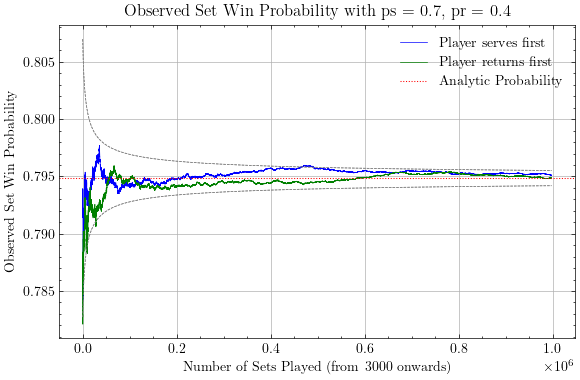

In [62]:
analytic_prob = analytic_set_prob_points(ps, pr)
colours = ['b', 'g']
fig, ax = plt.subplots(figsize=(6, 4)) # <--- THIS IS THE KEY ADDITION for size
labels = ['Player serves first', 'Player returns first']
start_idx = 3000
Z = 1.645
plus_std_dev = [analytic_prob + Z * (math.sqrt(analytic_prob * (1-analytic_prob)) / math.sqrt(runs)) for runs in range(start_idx, len(log[0]))]
minus_std_dev = [analytic_prob - Z * (math.sqrt(analytic_prob * (1-analytic_prob)) / math.sqrt(runs)) for runs in range(start_idx, len(log[0]))]
# 2. Your plotting code, now using 'ax' for plotting methods
for i, line_data in enumerate(log): # Changed 'line' to 'line_data' to avoid conflict with line objects
    ax.plot(line_data[start_idx:], color=colours[i % 2], linewidth=0.5, label=labels[i % 2])
    ax.plot(plus_std_dev, color='grey', linestyle='--', linewidth=0.5)
    ax.plot(minus_std_dev, color='grey', linestyle='--', linewidth=0.5)

ax.axhline(y=analytic_prob,
            color='red',
            linestyle=':',
            linewidth=0.75,
            label='Analytic Probability') # Corrected label for axhline

# 3. Set titles and labels using 'ax'
ax.set_title(f'Observed Set Win Probability with ps = {ps}, pr = {pr}')
ax.set_xlabel('Number of Sets Played (from 3000 onwards)') # Clarified x-axis due to slicing
ax.set_ylabel('Observed Set Win Probability')

# 4. Handle the legend
# Get handles and labels from the lines plotted in the loop
handles, labels = ax.get_legend_handles_labels()

# Manually create legend entries for the looped lines if they don't have labels
# Or, better, add labels in the loop if you want them to be distinct
# For now, I'll just use your original legend list if no labels were set on ax.plot
if not labels: # If ax.plot didn't have labels
    custom_lines = [plt.Line2D([0], [0], color=colours[0], lw=0.5),
                    plt.Line2D([0], [0], color=colours[1], lw=0.5)]
    ax.legend(custom_lines + [handles[-1]], ['Player serves first', 'Player returns first', 'Analytic Probability'])
else:
    # If your ax.plot lines already had labels, this would combine them with axhline's label
    ax.legend()


# 5. Add grid using 'ax'
ax.grid(True) # Using ax.grid() is good practice when you have an explicit axes object

# 6. Use tight_layout for better spacing
plt.tight_layout()

# 7. Show the plot
plt.show()
    
